# How to profile CUDA kernels in PyTorch


CUDA is async.



## CUDA profile torch.autograd.profiler

```python
with torch.autograd.profiler.profile(use_cuda=True) as prof:
    torch.square(b)
```

可以打印出 各种操作的用时：
```
=============
Profiling torch.square
=============
STAGE:2024-07-08 21:40:06 30357:30357 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-07-08 21:40:06 30357:30357 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-07-08 21:40:06 30357:30357 ActivityProfilerController.cpp:324] Completed Stage: Post Processing
-------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                     Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
             aten::square         0.60%      12.000us         4.12%      83.000us      83.000us       3.000us         0.15%       1.951ms       1.951ms             1  
                aten::pow         2.53%      51.000us         3.42%      69.000us      69.000us       1.946ms        99.74%       1.948ms       1.948ms             1   这里是使用的pow函数
        aten::result_type         0.10%       2.000us         0.10%       2.000us       2.000us       1.000us         0.05%       1.000us       1.000us             1  
                 aten::to         0.00%       0.000us         0.00%       0.000us       0.000us       1.000us         0.05%       1.000us       1.000us             1  
          cudaEventRecord         0.35%       7.000us         0.35%       7.000us       0.875us       0.000us         0.00%       0.000us       0.000us             8  
         cudaLaunchKernel         0.79%      16.000us         0.79%      16.000us      16.000us       0.000us         0.00%       0.000us       0.000us             1  
    cudaDeviceSynchronize        95.63%       1.928ms        95.63%       1.928ms       1.928ms       0.000us         0.00%       0.000us       0.000us             1  
-------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
Self CPU time total: 2.016ms
Self CUDA time total: 1.951ms

=============
Profiling a * a
=============
STAGE:2024-07-08 21:40:06 30357:30357 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-07-08 21:40:06 30357:30357 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-07-08 21:40:06 30357:30357 ActivityProfilerController.cpp:324] Completed Stage: Post Processing
-------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                     Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                aten::mul         1.54%      30.000us         2.26%      44.000us      44.000us       1.889ms       100.00%       1.889ms       1.889ms             1   而这里使用mul函数， mul函数要比pow快一些
          cudaEventRecord         0.36%       7.000us         0.36%       7.000us       3.500us       0.000us         0.00%       0.000us       0.000us             2  
         cudaLaunchKernel         0.72%      14.000us         0.72%      14.000us      14.000us       0.000us         0.00%       0.000us       0.000us             1  
    cudaDeviceSynchronize        97.38%       1.893ms        97.38%       1.893ms       1.893ms       0.000us         0.00%       0.000us       0.000us             1  
-------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
Self CPU time total: 1.944ms
Self CUDA time total: 1.889ms

=============
Profiling a ** 2
=============
STAGE:2024-07-08 21:40:06 30357:30357 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-07-08 21:40:06 30357:30357 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-07-08 21:40:06 30357:30357 ActivityProfilerController.cpp:324] Completed Stage: Post Processing
-------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                     Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                aten::pow         2.01%      39.000us         2.58%      50.000us      50.000us       1.876ms        99.89%       1.878ms       1.878ms             1  
        aten::result_type         0.05%       1.000us         0.05%       1.000us       1.000us       1.000us         0.05%       1.000us       1.000us             1  
                 aten::to         0.00%       0.000us         0.00%       0.000us       0.000us       1.000us         0.05%       1.000us       1.000us             1  
          cudaEventRecord         0.26%       5.000us         0.26%       5.000us       0.833us       0.000us         0.00%       0.000us       0.000us             6  
         cudaLaunchKernel         0.52%      10.000us         0.52%      10.000us      10.000us       0.000us         0.00%       0.000us       0.000us             1  
    cudaDeviceSynchronize        97.16%       1.883ms        97.16%       1.883ms       1.883ms       0.000us         0.00%       0.000us       0.000us             1  
-------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
Self CPU time total: 1.938ms
Self CUDA time total: 1.878ms
```


## pytorch profiler


In [2]:
import torch
from torch.profiler import profile, record_function, ProfilerActivity


# ## Default way to use profiler
# with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA]) as prof:
#     for _ in range(10):
#         a = torch.square(torch.randn(10000, 10000).cuda())

# prof.export_chrome_trace("trace.json")


## With warmup and skip
# https://pytorch.org/docs/stable/profiler.html

# Non-default profiler schedule allows user to turn profiler on and off
# on different iterations of the training loop;
# trace_handler is called every time a new trace becomes available
def trace_handler(prof):
    print(prof.key_averages().table(
        sort_by="self_cuda_time_total", row_limit=-1))
    prof.export_chrome_trace("/tmp/test_trace_" + str(prof.step_num) + ".json")

with torch.profiler.profile(
    activities=[
        torch.profiler.ProfilerActivity.CPU,
        torch.profiler.ProfilerActivity.CUDA,
    ],

    # In this example with wait=1, warmup=1, active=2, repeat=1,
    # profiler will skip the first step/iteration,
    # start warming up on the second, record
    # the third and the forth iterations,
    # after which the trace will become available
    # and on_trace_ready (when set) is called;
    # the cycle repeats starting with the next step

    schedule=torch.profiler.schedule(
        wait=1,
        warmup=1,
        active=2,
        repeat=1),
    on_trace_ready=trace_handler
    # on_trace_ready=torch.profiler.tensorboard_trace_handler('./log')
    # used when outputting for tensorboard
    ) as p:
        for iter in range(10):
            torch.square(torch.randn(10000, 10000).cuda())
            # send a signal to the profiler that the next iteration has started
            p.step()
            print(p.step_num)

1


STAGE:2024-07-08 22:22:35 46123:46123 ActivityProfilerController.cpp:314] Completed Stage: Warm Up


2
3
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                            aten::copy_         0.01%      58.000us         8.58%      59.287ms      29.643ms      58.993ms        93.84%      58.993ms      29.497ms             2  
                       Memcpy HtoD (Pageable -> Device)         0.00%       0.000us         0.00%       0.000us       0.000us      58.993ms        93.84%      58.993ms      29.497ms             2  
     

STAGE:2024-07-08 22:22:35 46123:46123 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-07-08 22:22:35 46123:46123 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


5
6
7
8
9
10


这段代码展示了如何使用 PyTorch 的分析器 (`torch.profiler.profile`) 来分析 CPU 和 CUDA 活动，并通过自定义的 `trace_handler` 处理跟踪数据。以下是对代码的详细分析以及解释为什么只生成了 `prof.step_num = 4` 的 JSON 文件。

### 代码分析

#### 1. 定义跟踪处理程序
```python
def trace_handler(prof):
    print(prof.key_averages().table(
        sort_by="self_cuda_time_total", row_limit=-1))
    prof.export_chrome_trace("/tmp/test_trace_" + str(prof.step_num) + ".json")
```
- `trace_handler` 函数在跟踪数据准备好时被调用。
- 它打印按 CUDA 总时间排序的性能摘要表。
- 它导出 Chrome 跟踪文件，文件名中包含当前步骤编号 (`prof.step_num`)。

#### 2. 设置分析器
```python
with torch.profiler.profile(
    activities=[
        torch.profiler.ProfilerActivity.CPU,
        torch.profiler.ProfilerActivity.CUDA,
    ],

    schedule=torch.profiler.schedule(
        wait=1,
        warmup=1,
        active=2,
        repeat=1),
    on_trace_ready=trace_handler
    ) as p:
        for iter in range(10):
            torch.square(torch.randn(10000, 10000).cuda())
            p.step()
            print(p.step_num)
```
- 配置分析器以捕获 CPU 和 CUDA 活动。
- 设置调度策略：跳过第 1 步（`wait=1`），预热第 2 步（`warmup=1`），在第 3 和第 4 步记录数据（`active=2`），然后重复这个循环（`repeat=1`）。
- 在每个循环中创建一个 10000x10000 的随机张量，并在 CUDA 上进行平方计算。
- `p.step()` 信号告知分析器新一轮迭代已经开始，并打印当前步骤编号。

### 执行流程

1. **迭代 0**：跳过（`wait=1`）。
2. **迭代 1**：预热（`warmup=1`）。
3. **迭代 2-3**：活跃期，分析器记录数据（`active=2`）。
4. **迭代 4**：触发 `on_trace_ready`，调用 `trace_handler`，生成 `test_trace_4.json`。
5. **迭代 5**：跳过（`wait=1`）。
6. **迭代 6**：预热（`warmup=1`）。
7. **迭代 7-8**：活跃期，分析器记录数据（`active=2`）。
8. **迭代 9**：触发 `on_trace_ready`，调用 `trace_handler`，生成 `test_trace_9.json`。

### 为什么只生成了 `prof.step_num = 4` 的 JSON 文件？

可能原因有：

1. **代码修改未完成**：在运行上述代码时可能只执行了前五个步骤，从而只生成了 `test_trace_4.json` 文件。如果循环完整运行，应该还会生成 `test_trace_9.json` 文件。
2. **文件覆盖**：在某些情况下，如果文件名重复，后续文件可能覆盖之前生成的文件。检查代码是否生成多个文件，或在调试期间是否更改了文件路径。
3. **系统问题**：运行环境或文件系统的限制可能影响文件的生成和保存。

确保代码完整运行所有 10 次迭代，并确认文件路径和命名无误，以便正确生成所有预期的 JSON 文件。

当我增加iter的range时，也只proflie了一次

代码运行后生成 /tmp/test_trace_4.json

在 chrome 中打开 [chrome://tracing/](chrome://tracing/) 然后将json拖进去，即可可视化展示profile  
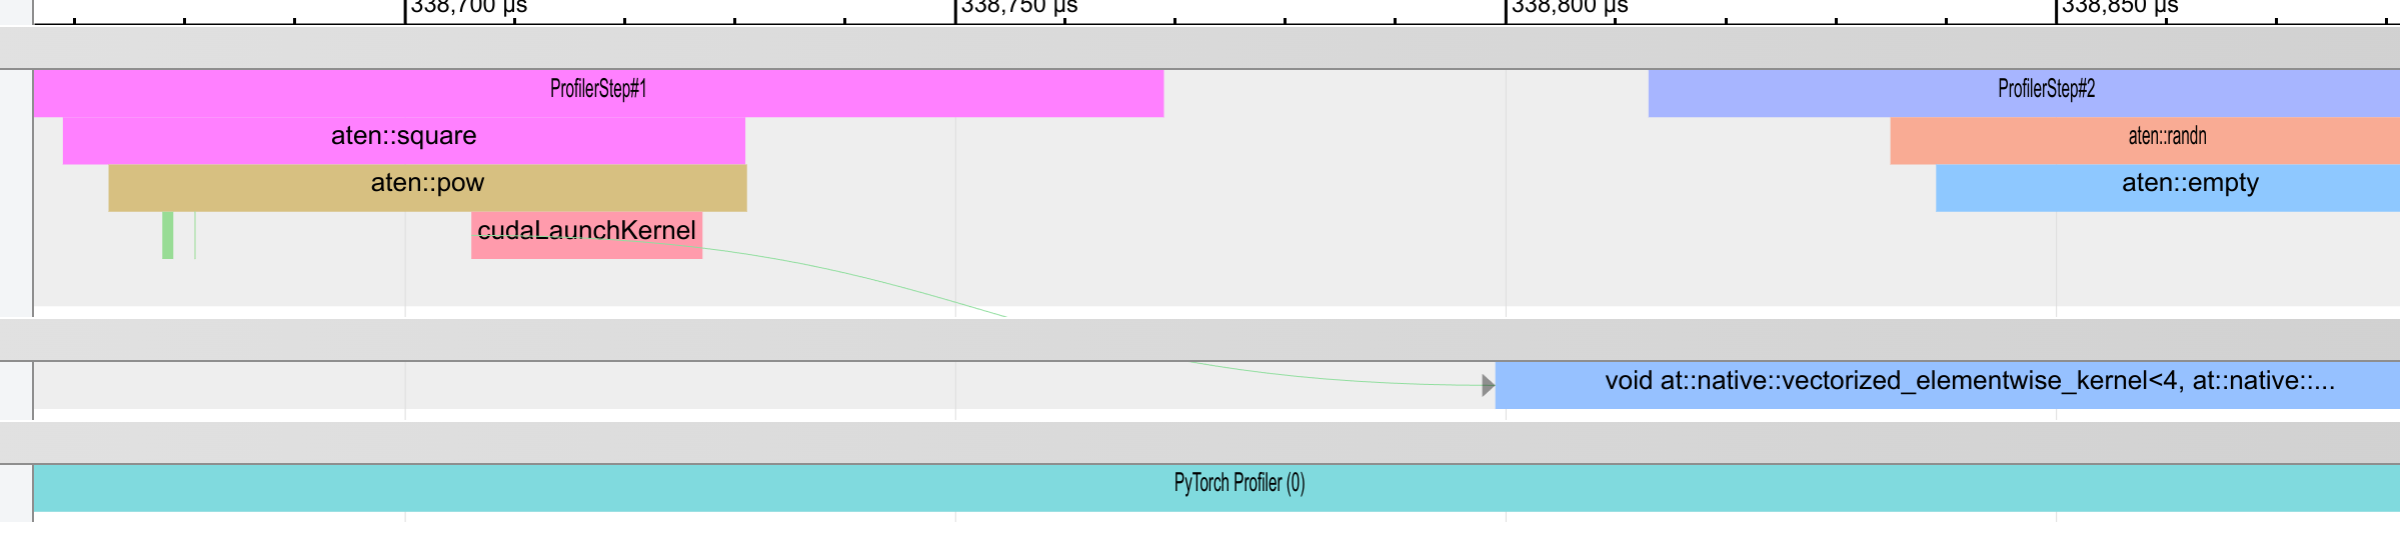


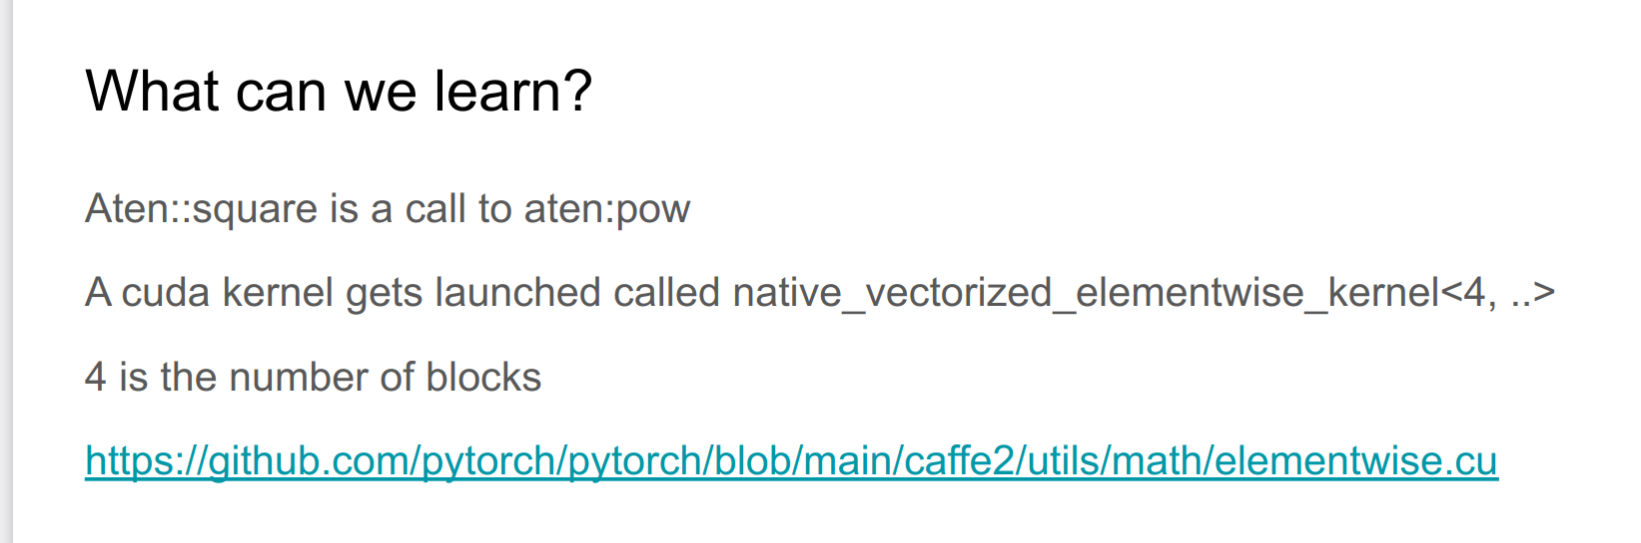

## 如何自定义 cpp extensions

可以通过pybind ， 最简单的方法是通过 load inline方式，指定build_directory 可以看到 代码生成与编译的目录

> 有一个libstdcxx.so 版本不对的问题，找出对应的so包重新链接可解决  https://blog.csdn.net/qq_43282035/article/details/130575562

In [1]:
import torch
from torch.utils.cpp_extension import load_inline

cpp_source = """
std::string hello_world() {
  return "Hello World!";
}
"""

my_module = load_inline(
    name='my_module',
    cpp_sources=[cpp_source],
    functions=['hello_world'],
    verbose=True,
    build_directory='./lecture_001/tmp'
)

print(my_module.hello_world())

Emitting ninja build file /home/ionlz/project/manwcismo/cuda-mode/chap1/lecture_001/tmp/build.ninja...
Building extension module my_module...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


ninja: no work to do.
Hello World!


Loading extension module my_module...


一个更复杂的样例

In [1]:
# Look at this test for inspiration
# https://github.com/pytorch/pytorch/blob/main/test/test_cpp_extensions_jit.py

import torch
from torch.utils.cpp_extension import load_inline

# Define the CUDA kernel and C++ wrapper
cuda_source = '''
__global__ void square_matrix_kernel(const float* matrix, float* result, int width, int height) {
    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int col = blockIdx.x * blockDim.x + threadIdx.x;

    if (row < height && col < width) {
        int idx = row * width + col;
        result[idx] = matrix[idx] * matrix[idx];
    }
}

torch::Tensor square_matrix(torch::Tensor matrix) {
    const auto height = matrix.size(0);
    const auto width = matrix.size(1);

    auto result = torch::empty_like(matrix);

    dim3 threads_per_block(16, 16);
    dim3 number_of_blocks((width + threads_per_block.x - 1) / threads_per_block.x,
                          (height + threads_per_block.y - 1) / threads_per_block.y);

    square_matrix_kernel<<<number_of_blocks, threads_per_block>>>(
        matrix.data_ptr<float>(), result.data_ptr<float>(), width, height);

    return result;
    }
'''

cpp_source = "torch::Tensor square_matrix(torch::Tensor matrix);" # cpp入口

# Load the CUDA kernel as a PyTorch extension
square_matrix_extension = load_inline(
    name='square_matrix_extension',
    cpp_sources=cpp_source,
    cuda_sources=cuda_source,
    functions=['square_matrix'],
    with_cuda=True,
    extra_cuda_cflags=["-O2"],
    build_directory='./lecture_001/load_inline_cuda',
    # extra_cuda_cflags=['--expt-relaxed-constexpr']
)

a = torch.tensor([[1., 2., 3.], [4., 5., 6.]], device='cuda')
print(square_matrix_extension.square_matrix(a))

# (cudamode) ubuntu@ip-172-31-9-217:~/cudamode/cudamodelecture1$ python load_inline.py 
# tensor([[ 1.,  4.,  9.],
#         [16., 25., 36.]], device='cuda:0')


## No great interaction with ncu

# (cudamode) ubuntu@ip-172-31-9-217:~/cudamode/cudamodelecture1$ ncu python load_inline.py 
# ==PROF== Connected to process 55916 (/opt/conda/envs/cudamode/bin/python3.10)
# /opt/conda/envs/cudamode/lib/python3.10/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 36: API call is not supported in the installed CUDA driver (Triggered internally at /opt/conda/conda-bld/pytorch_1702400410390/work/c10/cuda/CUDAFunctions.cpp:108.)
#   return torch._C._cuda_getDeviceCount() > 0
# No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'
# Traceback (most recent call last):
#   File "/home/ubuntu/cudamode/cudamodelecture1/load_inline.py", line 7, in <module>
#     a = torch.tensor([[1., 2., 3.], [4., 5., 6.]], device='cuda')
#   File "/opt/conda/envs/cudamode/lib/python3.10/site-packages/torch/cuda/__init__.py", line 298, in _lazy_init
#     torch._C._cuda_init()
# RuntimeError: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 36: API call is not supported in the installed CUDA driver
# ==PROF== Disconnected from process 55916
# ==ERROR== The application returned an error code (1).
# ==WARNING== No kernels were profiled.
# ==WARNING== Profiling kernels launched by child processes requires the --target-processes all option.

RuntimeError: Error building extension 'square_matrix_extension': [1/2] /opt/cuda/bin/nvcc --generate-dependencies-with-compile --dependency-output cuda.cuda.o.d -DTORCH_EXTENSION_NAME=square_matrix_extension -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /home/ionlz/.conda/envs/mingpt/lib/python3.12/site-packages/torch/include -isystem /home/ionlz/.conda/envs/mingpt/lib/python3.12/site-packages/torch/include/torch/csrc/api/include -isystem /home/ionlz/.conda/envs/mingpt/lib/python3.12/site-packages/torch/include/TH -isystem /home/ionlz/.conda/envs/mingpt/lib/python3.12/site-packages/torch/include/THC -isystem /opt/cuda/include -isystem /home/ionlz/.conda/envs/mingpt/include/python3.12 -D_GLIBCXX_USE_CXX11_ABI=0 -D__CUDA_NO_HALF_OPERATORS__ -D__CUDA_NO_HALF_CONVERSIONS__ -D__CUDA_NO_BFLOAT16_CONVERSIONS__ -D__CUDA_NO_HALF2_OPERATORS__ --expt-relaxed-constexpr -gencode=arch=compute_86,code=compute_86 -gencode=arch=compute_86,code=sm_86 --compiler-options '-fPIC' -O2 -std=c++17 -c /home/ionlz/project/manwcismo/cuda-mode/chap1/lecture_001/load_inline_cuda/cuda.cu -o cuda.cuda.o 
[31mFAILED: [0mcuda.cuda.o 
/opt/cuda/bin/nvcc --generate-dependencies-with-compile --dependency-output cuda.cuda.o.d -DTORCH_EXTENSION_NAME=square_matrix_extension -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /home/ionlz/.conda/envs/mingpt/lib/python3.12/site-packages/torch/include -isystem /home/ionlz/.conda/envs/mingpt/lib/python3.12/site-packages/torch/include/torch/csrc/api/include -isystem /home/ionlz/.conda/envs/mingpt/lib/python3.12/site-packages/torch/include/TH -isystem /home/ionlz/.conda/envs/mingpt/lib/python3.12/site-packages/torch/include/THC -isystem /opt/cuda/include -isystem /home/ionlz/.conda/envs/mingpt/include/python3.12 -D_GLIBCXX_USE_CXX11_ABI=0 -D__CUDA_NO_HALF_OPERATORS__ -D__CUDA_NO_HALF_CONVERSIONS__ -D__CUDA_NO_BFLOAT16_CONVERSIONS__ -D__CUDA_NO_HALF2_OPERATORS__ --expt-relaxed-constexpr -gencode=arch=compute_86,code=compute_86 -gencode=arch=compute_86,code=sm_86 --compiler-options '-fPIC' -O2 -std=c++17 -c /home/ionlz/project/manwcismo/cuda-mode/chap1/lecture_001/load_inline_cuda/cuda.cu -o cuda.cuda.o 
/home/ionlz/.conda/envs/mingpt/lib/python3.12/site-packages/torch/include/ATen/core/boxing/impl/boxing.h:41:104: 错误：expected primary-expression before ‘>’ token
   41 | struct has_ivalue_to<T, guts::void_t<decltype(std::declval<IValue>().to<T>())>>
      |                                                                                                        ^
/home/ionlz/.conda/envs/mingpt/lib/python3.12/site-packages/torch/include/ATen/core/boxing/impl/boxing.h:41:107: 错误：expected primary-expression before ‘)’ token
   41 | struct has_ivalue_to<T, guts::void_t<decltype(std::declval<IValue>().to<T>())>>
      |                                                                                                           ^
ninja: build stopped: subcommand failed.
